**notebook outdated (it is based on premise that some of the manual data has to be revised, and identifying cells that seem to contain errors): all data has been revised, so this is superfluous**


# Updated draft of evaluation

for each FUA:
* load data
* create evaluation grids
* load info on which cells are still under manual revision (exclude from evaluation FOR NOW)
* for each evaluation variable, check how errors are distributed: on map; by method

In [1]:
import os
import pathlib

import folium
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import momepy as mm
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import gaussian_kde

from core import stats, utils, viz

# %watermark -w
# %watermark -iv

Define which variables to evaluate

In [2]:
# which variables to evaluate
eval_vars = [
    "edge_count",
    "edge_length",
    "node_count",
    "avg_degree",
    "stroke_count",
    "stroke_length_sum",
    "stroke_length_max",
]

Define which methods to evaluate

In [3]:
# which methods to evaluate
methods_to_evaluate = [
    "cityseer",
    "original",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "manual",
    "neatnet",
]

Define which method pairs to compare

In [4]:
# which method pairs to compare
methodpairs_to_compare = [
    ("cityseer", "manual"),
    ("original", "manual"),
    ("osmnx", "manual"),
    ("parenx-voronoi", "manual"),
    ("parenx-skeletonize", "manual"),
    ("neatnet", "manual"),
]

Directories for evaluation results

In [5]:
evalfolder = "../../evaluation/"
os.makedirs(evalfolder, exist_ok=True)
subfolders = [evalfolder + str(fua) for fua in utils.fua_city]
for sub in subfolders:
    os.makedirs(sub, exist_ok=True)

Choose use case (FUA)

**once workflow is fixed: run for all FUAs**

In [6]:
# which FUA?
fua = 869

# which h3 resolution?
res = 9

In [7]:
# read in base data
meta = utils.read_sample_data()
geom = meta.loc[meta.eFUA_ID == fua, "geometry"]
city = meta.loc[meta.eFUA_ID == fua, "eFUA_name"].values[0]

gdf_orig = utils.read_original(fua)
proj_crs = gdf_orig.crs

# Make grid
base_grid = utils.make_grid(fua, res, proj_crs)

# get info on cells with revised data
deltas = gpd.read_file(f"../../revision/{fua}/deltas_updated.gpkg")

# read results from all methods into dict
methods = {}

for method in methods_to_evaluate:
    print(f"Reading in results for {method}")
    gdf = utils.read_results(fua, method, proj_crs)
    gdf = gdf[~gdf.normalize().duplicated()].copy().reset_index(drop=True)
    G = mm.gdf_to_nx(gdf, length="length", integer_labels=True)
    nodes, edges = mm.nx_to_gdf(G)

    # add node degrees
    nodes = stats.add_node_degree(nodes, G)

    # add stroke IDs
    coins = mm.COINS(edges, angle_threshold=120, flow_mode=True)
    edges["stroke_id"] = coins.stroke_attribute()
    stroke_gdf = coins.stroke_gdf()

    methods[method] = {}
    methods[method]["gdf"] = gdf
    methods[method]["graph"] = G
    methods[method]["nodes"] = nodes
    methods[method]["edges"] = edges

    ### grid with stats eval for this method only
    grid = base_grid.copy()

    # add ratio columns to grid
    grid[["edge_count", "edge_length"]] = grid.apply(
        lambda x: stats.get_edge_stats(edges, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )
    grid[["node_count", "node_degrees", "avg_degree"]] = grid.apply(
        lambda x: stats.get_node_stats(nodes, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    grid[["stroke_count", "stroke_length_sum", "stroke_length_max"]] = grid.apply(
        lambda x: stats.get_stroke_stats(edges, stroke_gdf, x.geometry),  # noqa: B023
        axis=1,
        result_type="expand",
    )

    # add info on which cells have to be verified still
    grid["to_verify_total"] = deltas["to_verify_total"]

    # save grid to dict
    methods[method]["grid"] = grid

Reading in results for cityseer


ValueError: Columns must be same length as key

**Evaluation for different eval vars**

In [ ]:
# make subfolders for evaluation plots
for subfolder in ["../../plots/", "../../plots/evaluation/"] + [
    f"../../plots/evaluation/{fua}" for fua in utils.fua_city
]:
    os.makedirs(subfolder, exist_ok=True)

In [ ]:
## plotting parameters
plotparams = {
    "neatnet": {"color": "black", "alpha": 0.2, "zorder": 0},
    "parenx-voronoi": {"color": "gold", "alpha": 0.5, "zorder": 3},
    "parenx-skeletonize": {"color": "deepskyblue", "alpha": 0.5, "zorder": 2},
    "cityseer": {"color": "pink", "alpha": 0.7, "zorder": 1},
    "osmnx": {"color": "plum", "alpha": 0.7, "zorder": 1},
}

In [ ]:
methods_to_compare = [
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
    "neatnet",
]

Assuming that 

$$ var_{original} \geq var_{manual}  $$ 

holds for all cells, we compute the weight for variable in each cell as the ratio of its value in the original vs. the manually simplified data set,

$$ weight(cell) = \frac{var_{original}(cell)-var_{manual}(cell)}{var_{orig}(cell)}  $$

This will give $ weight(cell) \leq 1 $ for all cells.

**generate plots for all variables, for one FUA**

In [ ]:
# which variables to evaluate
eval_vars = [
    "edge_count",
    "edge_length",
    "node_count",
    "avg_degree",
    "stroke_count",
    "stroke_length_sum",
    # "stroke_length_max", # this was giving error messages - not relevant enough to debug for now
]

for fua in utils.fua_city:
    city = utils.fua_city[fua]
    print(f"Generating plots for {city}")

    for eval_var in eval_vars:
        # get weights
        weights = (
            methods["original"]["grid"][eval_var] - methods["manual"]["grid"][eval_var]
        ) / methods["original"]["grid"][eval_var]

        # mask to only compute metric for cells where there is data in the original data set
        mask = methods["original"]["grid"][eval_var] > 0

        #### generate KDE PDFs

        kdes = {}

        for method in methods_to_compare:
            # print(f"evaluating {eval_var} for {method}")

            # absolute diffs baseline for this eval var
            delta_comp = (
                methods["original"]["grid"][eval_var]
                - methods[method]["grid"][eval_var]
            )

            # delta base is the same for each method (because it is based on orig-manual)
            # somewhat inefficiently but still keeping it in the for loop
            # (for confusion minimization)
            delta_base = (
                methods["original"]["grid"][eval_var]
                - methods["manual"]["grid"][eval_var]
            )

            # weight (per cell)
            delta_base = delta_base * weights
            delta_comp = delta_comp * weights

            # mask to remove NaNs
            delta_base = delta_base[mask]
            delta_comp = delta_comp[mask]

            kdes[method] = {}
            kdes[method]["base"] = gaussian_kde(delta_base)
            kdes[method]["comp"] = gaussian_kde(delta_comp)
            kdes[method]["max"] = max([max(delta_base), max(delta_comp)])

        # get linspace for KDE
        mymin = 0
        mymax = max(
            [kdes[method]["max"] for method in methods_to_compare if method != "osmnx"]
        )
        mypoints = 200
        mylinspace = np.linspace(mymin, mymax, mypoints)

        ### MAKE AND SAVE ALL-IN-ONE PLOT

        # make plot
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))

        for method in methods_to_compare:
            ax.fill_between(
                mylinspace,
                kdes[method]["comp"](mylinspace),
                kdes[method]["base"](mylinspace),
                color=plotparams[method]["color"],
                alpha=plotparams[method]["alpha"],
                label=f"base vs. {method}",
                zorder=plotparams[method]["zorder"],
            )
        ax.plot(
            mylinspace,
            kdes[method]["base"](mylinspace),
            color="white",
            label="baseline",
            linestyle="dotted",
            lw=1,
            zorder=5,
        )
        ax.set_xlabel(f"Delta values for {eval_var}")
        # ax.set_xlim([min(delta_base), max(delta_base)])
        ax.set_xlim([0, mymax])
        ax.set_ylabel("Probability density")
        ax.set_title(f"Hex-cell-wise evaluation for {eval_var}")
        ax.legend()

        fig.savefig(
            f"../../plots/evaluation/{fua}/single_{eval_var}.png",
            dpi=300,
            bbox_inches="tight",
        )

        plt.close()

        ### MAKE AND SAVE SUBPLOTS FIGURE

        # make plot
        fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharex=False, sharey=False)

        methods_subplots = [
            "cityseer",
            "osmnx",
            "parenx-voronoi",
            "parenx-skeletonize",
        ]

        for ax, method in zip(axs.flat, methods_subplots, strict=False):
            # method X
            ax.fill_between(
                mylinspace,
                kdes[method]["comp"](mylinspace),
                kdes[method]["base"](mylinspace),
                color=plotparams[method]["color"],
                alpha=plotparams[method]["alpha"],
                label=f"base vs. {method}",
                zorder=plotparams[method]["zorder"],
            )
            # manual
            ax.fill_between(
                mylinspace,
                kdes["neatnet"]["comp"](mylinspace),
                kdes["neatnet"]["base"](mylinspace),
                color=plotparams["neatnet"]["color"],
                alpha=plotparams["neatnet"]["alpha"],
                label="base vs. neatnet",
                zorder=plotparams["neatnet"]["zorder"],
            )

            ax.plot(
                mylinspace,
                kdes[method]["base"](mylinspace),
                color="red",
                label="baseline",
                linestyle="dotted",
            )
            # ax.set_xlim([min(delta_base), max(delta_base)])
            ax.set_xlim([0, mymax])
            ax.set_xlabel(f"Delta values for {eval_var}")
            ax.set_ylabel("Probability density")
            ax.set_title(f"neatnet vs. {method}")
            ax.legend()
        plt.suptitle(f"Hex-cell-wise evaluation for {eval_var}")
        plt.tight_layout()

        fig.savefig(
            f"../../plots/evaluation/{fua}/multi_{eval_var}.png",
            dpi=300,
            bbox_inches="tight",
        )

        plt.close()

Generating plots for Aleppo
Generating plots for Auckland
Generating plots for Bucaramanga
Generating plots for Douala
Generating plots for Liège
Generating plots for Salt Lake City
Generating plots for Wuhan


***

***

explore viz

In [ ]:
# # plot manual data
# method = "manual"

# m = methods[method]["gdf"].explore(
#     tiles="cartodb.positron",
#     name=method,
#     color="red",
#     style_kwds={"weight":2}
# )

# # plot original data
# method = "original"
# methods[method]["gdf"].explore(
#     m=m,
#     name=method,
#     color="black",
#     style_kwds={"weight":1}
# )

# # # plot tiles
# # m = deltas.explore(
# #     tiles="cartodb.positron", column="to_verify_total", name="cells", cmap="Accent"
# # )
# folium.LayerControl().add_to(m)
# m


***

Plot playground: for just one variable

In [ ]:
eval_var = "edge_length"
fua = 869

In [ ]:
# get weights
weights = (
    methods["original"]["grid"][eval_var] - methods["manual"]["grid"][eval_var]
) / methods["original"]["grid"][eval_var]

# mask to only compute metric for cells where there is data in the original data set
mask = methods["original"]["grid"][eval_var] > 0

#### generate KDE PDFs

kdes = {}

for method in methods_to_compare:
    # print(f"evaluating {eval_var} for {method}")

    # absolute diffs baseline for this eval var
    delta_comp = (
        methods["original"]["grid"][eval_var] - methods[method]["grid"][eval_var]
    )

    # delta base is the same for each method (because it is based on orig-manual)
    # somewhat inefficiently but still keeping it in the for loop
    # (for confusion minimization)
    delta_base = (
        methods["original"]["grid"][eval_var] - methods["manual"]["grid"][eval_var]
    )

    # weight (per cell)
    delta_base = delta_base * weights
    delta_comp = delta_comp * weights

    # mask to remove NaNs
    delta_base = delta_base[mask]
    delta_comp = delta_comp[mask]

    kdes[method] = {}
    kdes[method]["base"] = gaussian_kde(delta_base)
    kdes[method]["comp"] = gaussian_kde(delta_comp)
    kdes[method]["max"] = max([max(delta_base), max(delta_comp)])

# get linspace for KDE
mymin = 0
mymax = max([kdes[method]["max"] for method in methods_to_compare if method != "osmnx"])
mypoints = 200
mylinspace = np.linspace(mymin, mymax, mypoints)

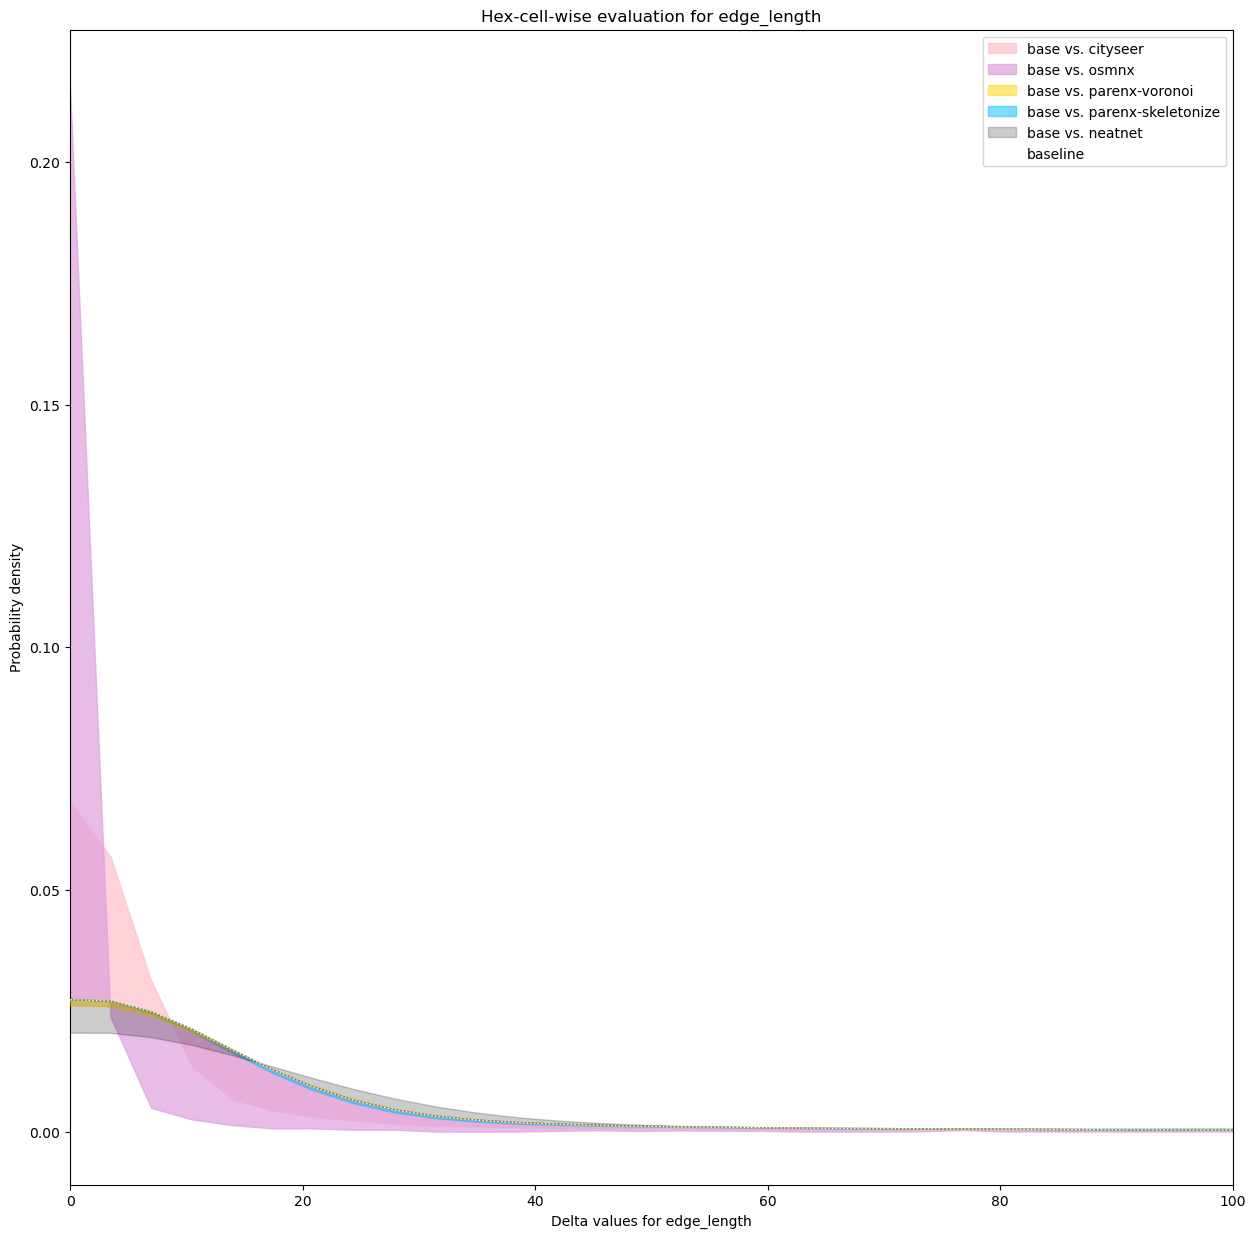

In [ ]:
### MAKE AND SAVE ALL-IN-ONE PLOT

## plotting parameters
plotparams = {
    "neatnet": {"color": "black", "alpha": 0.2, "zorder": 4},
    "parenx-voronoi": {"color": "gold", "alpha": 0.5, "zorder": 3},
    "parenx-skeletonize": {"color": "deepskyblue", "alpha": 0.5, "zorder": 2},
    "cityseer": {"color": "pink", "alpha": 0.7, "zorder": 1},
    "osmnx": {"color": "plum", "alpha": 0.7, "zorder": 1},
}


# make plot
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

for method in methods_to_compare:
    ax.fill_between(
        mylinspace,
        kdes[method]["comp"](mylinspace),
        kdes[method]["base"](mylinspace),
        color=plotparams[method]["color"],
        alpha=plotparams[method]["alpha"],
        label=f"base vs. {method}",
        zorder=plotparams[method]["zorder"],
    )
ax.plot(
    mylinspace,
    kdes[method]["base"](mylinspace),
    color="white",
    label="baseline",
    linestyle="dotted",
    lw=1,
    zorder=5,
)
ax.set_xlabel(f"Delta values for {eval_var}")
# ax.set_xlim([min(delta_base), max(delta_base)])
ax.set_xlim([0, 100])
ax.set_ylabel("Probability density")
ax.set_title(f"Hex-cell-wise evaluation for {eval_var}")
ax.legend()

# fig.savefig(
#     f"../../plots/evaluation/{fua}/single_{eval_var}.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.close()
plt.show()

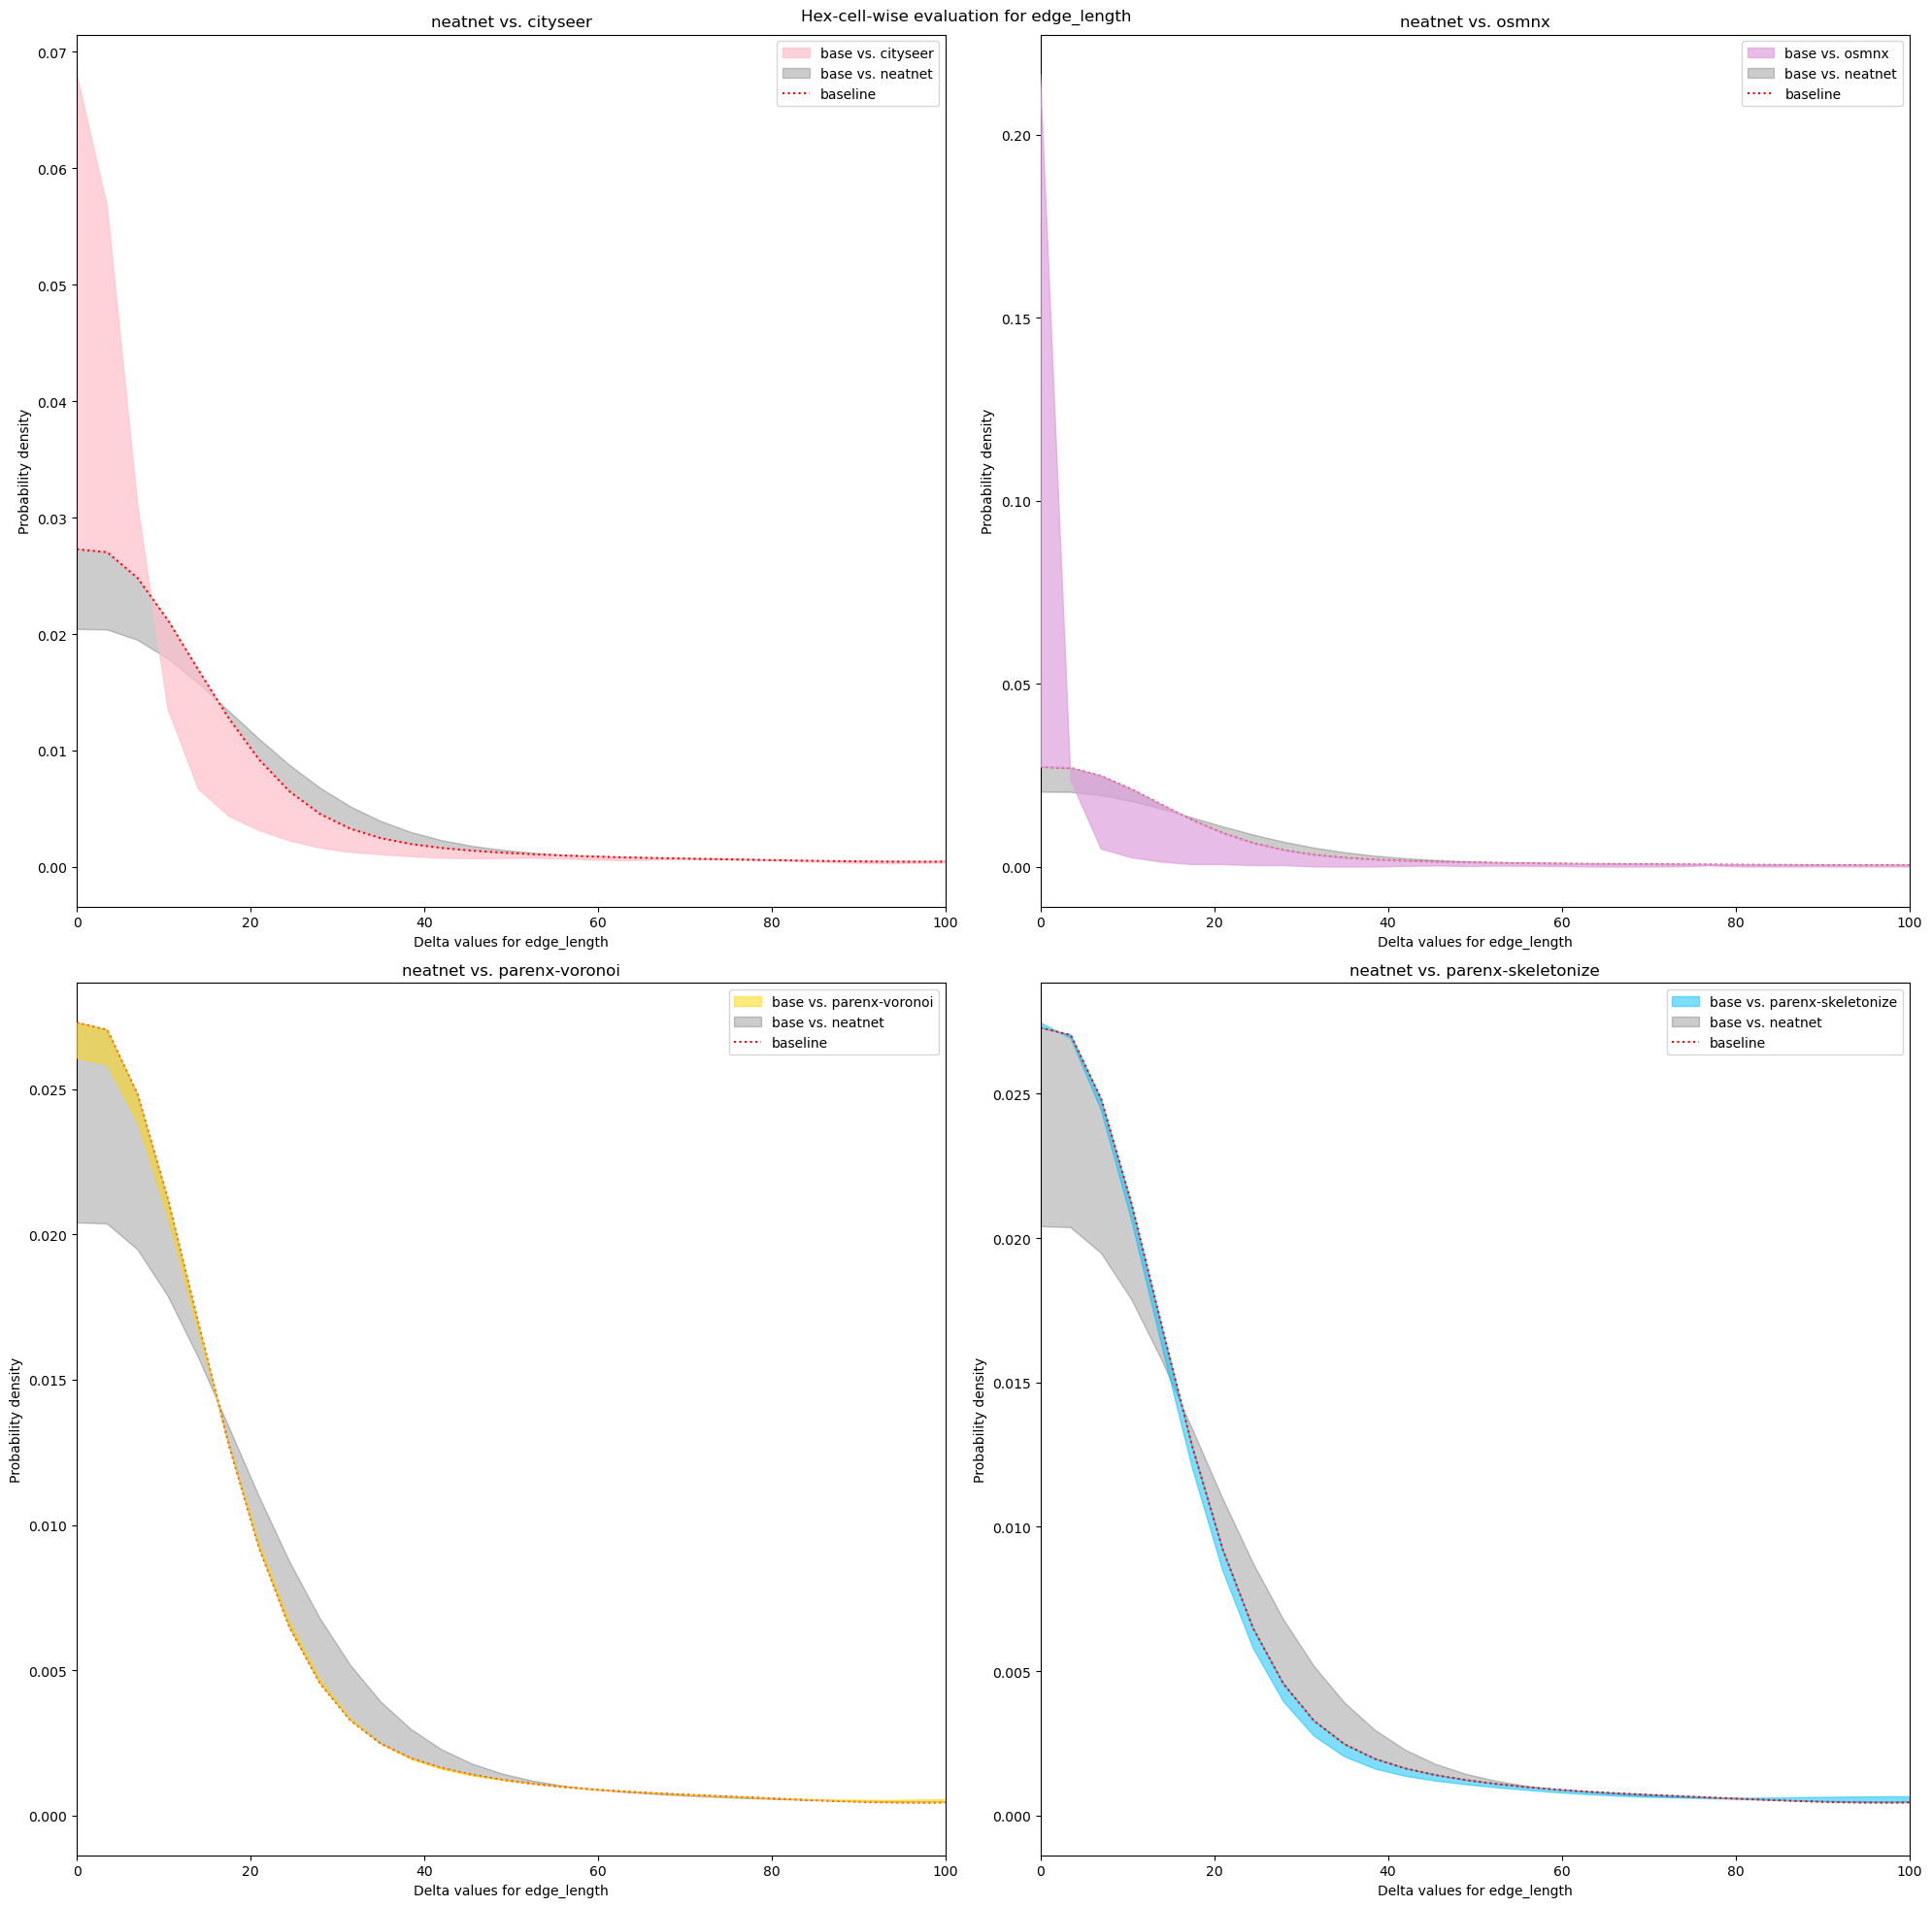

In [ ]:
### MAKE AND SAVE SUBPLOTS FIGURE

## plotting parameters
plotparams = {
    "neatnet": {"color": "black", "alpha": 0.2, "zorder": 0},
    "parenx-voronoi": {"color": "gold", "alpha": 0.5, "zorder": 3},
    "parenx-skeletonize": {"color": "deepskyblue", "alpha": 0.5, "zorder": 2},
    "cityseer": {"color": "pink", "alpha": 0.7, "zorder": 1},
    "osmnx": {"color": "plum", "alpha": 0.7, "zorder": 4},
}

# make plot
fig, axs = plt.subplots(
    2,
    2,
    figsize=(20, 20),
    # sharex=True, sharey=True
)

methods_subplots = [
    "cityseer",
    "osmnx",
    "parenx-voronoi",
    "parenx-skeletonize",
]

for ax, method in zip(axs.flat, methods_subplots, strict=False):
    # method X
    ax.fill_between(
        mylinspace,
        kdes[method]["comp"](mylinspace),
        kdes[method]["base"](mylinspace),
        color=plotparams[method]["color"],
        alpha=plotparams[method]["alpha"],
        label=f"base vs. {method}",
        zorder=plotparams[method]["zorder"],
    )
    # manual
    ax.fill_between(
        mylinspace,
        kdes["neatnet"]["comp"](mylinspace),
        kdes["neatnet"]["base"](mylinspace),
        color=plotparams["neatnet"]["color"],
        alpha=plotparams["neatnet"]["alpha"],
        label="base vs. neatnet",
        zorder=plotparams["neatnet"]["zorder"],
    )

    ax.plot(
        mylinspace,
        kdes[method]["base"](mylinspace),
        color="red",
        label="baseline",
        linestyle="dotted",
    )
    # ax.set_xlim([min(delta_base), max(delta_base)])
    ax.set_xlim([0, 100])
    ax.set_xlabel(f"Delta values for {eval_var}")
    ax.set_ylabel("Probability density")
    ax.set_title(f"neatnet vs. {method}")
    ax.legend()
plt.suptitle(f"Hex-cell-wise evaluation for {eval_var}")
plt.tight_layout()

# fig.savefig(
#     f"../../plots/evaluation/{fua}/multi_{eval_var}.png",
#     dpi=300,
#     bbox_inches="tight",
# )

# plt.close()
plt.show()